<a href="https://colab.research.google.com/github/halen48/DCGAN/blob/main/GAN_Celeb_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><a href="https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html">Deep Convolutional Generative Adversarial Networks</a></h1>
<h2>Autor do código: <a href="https://twitter.com/fchollet">François Chollet</a>

<h2>Adaptação e transposição para o Notebook: <a href="https://github.com/halen48/">Guilherme Novaes</a></h2>

#Dependências

In [14]:
%tensorflow_version 2.x # Força utilizar o tensorflow versão 2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
import json
from zipfile import ZipFile


#Constantes e Parâmetros

In [15]:
batch_size =  30#@param {type:"integer"}
image_size = 64 #@param {type:"integer"}
latent_dim = 128 #@param {type:"integer"}
image_channels = 3 #@param {type:"integer"}
lr = 0.0001 #@param {type:"number"}
epochs =  500#@param {type:"number"}
num_imgs_save =  9#@param {type:"number"}

work_path = '/drive/MyDrive/GAN/' #@param{type:"string"}

import os
from google.colab import drive
import re

drive.mount('/content/drive')

dir = os.getcwd()+work_path

import sys
sys.path.insert(0, dir)

work_path = '.' + work_path
try:
  os.makedirs(work_path)
except FileExistsError:
  print("Diretório [%s] já criado..."%work_path)
for i in range(num_imgs_save):
  try:
    os.makedirs(work_path+"/%d"%i)
  except FileExistsError:
    print("Diretório [%d] já criado..."%i)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diretório [./drive/MyDrive/GAN/] já criado...
Diretório [0] já criado...
Diretório [1] já criado...
Diretório [2] já criado...
Diretório [3] já criado...
Diretório [4] já criado...
Diretório [5] já criado...
Diretório [6] já criado...
Diretório [7] já criado...
Diretório [8] já criado...


#Carregar o dataset <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">Celeb-A Faces dataset</a>

In [16]:
try:
  # Para rodar em TPU, o dataset precisa estar na nuvem do google (GCS, e não o google drive)!!
  os.makedirs("celeba_gan")
  url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
  output = "celeba_gan/data.zip"
  gdown.download(url, output, quiet=True)
  with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")
except FileExistsError:
  print("Dataset já foi baixado!")

dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(image_size, image_size), batch_size=batch_size
)

Dataset já foi baixado!
Found 202599 files belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


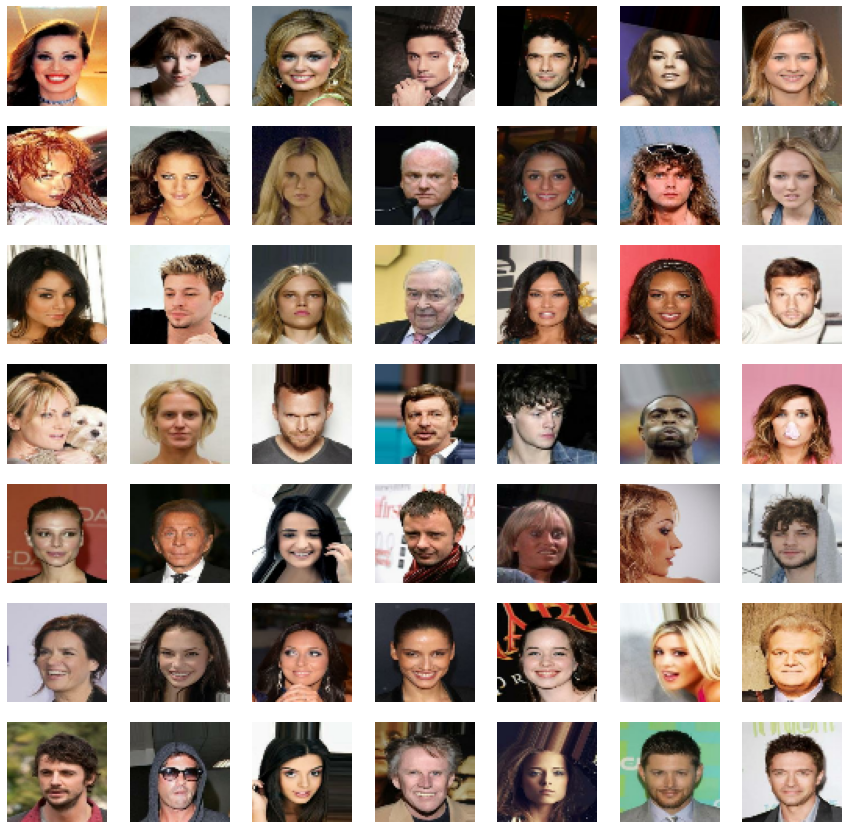

In [17]:
from matplotlib.pyplot import figure
figure(figsize=(15, 15))

i = 0
plot_dim = 7

for x in dataset:
  plt.subplot(plot_dim, plot_dim, 1 + i)
  plt.axis('off')
  plt.imshow((x.numpy()).astype("int32")[0])
  i+=1
  if(i == plot_dim*plot_dim):
    break
plt.show()

##Normaliza os valores das imagens

In [18]:
dataset = dataset.map(lambda x: x / 255.0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


#Definições dos modelos

##Discriminador

In [19]:
try:
  discriminator = keras.models.load_model(work_path+'discriminator.h5')
except Exception as e:
  print("Criando novo discriminator [%s]"%e)
  discriminator = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Criando novo discriminator [No model config found in the file at ./drive/MyDrive/GAN/discriminator.h5.]
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
               

##Gerador

In [20]:
try:
  generator = keras.models.load_model(work_path+'generator.h5')
except Exception as e:
  print("Criando novo generator [%s]"%e)
  generator = keras.Sequential(
      [
          keras.Input(shape=(latent_dim,)),
          layers.Dense(8 * 8 * 128),
          layers.Reshape((8, 8, 128)),
          layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
      ],
      name="generator",
  )
generator.summary()


Criando novo generator [No model config found in the file at ./drive/MyDrive/GAN/generator.h5.]
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                           

##Rotina para salvar as imagens geradas durante as iterações

In [21]:
tf.config.run_functions_eagerly(True)

def save_imgs(epoch, num_img, latent_dim, generator, discriminator):
  random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
  generated_images = generator(random_latent_vectors)
  generated_images *= 255
  generated_images.numpy()
  for id in range(num_img):
      img = keras.preprocessing.image.array_to_img(generated_images[id])
      img.save(work_path+"%d/generated_img_%03d.png" % (id,epoch))

In [22]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=num_imgs_save, latent_dim=latent_dim):
        self.num_img = num_imgs_save
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        save_imgs(epoch,self.num_img, self.latent_dim, self.model.generator, self.model.discriminator)        

##Rotina para salvar os pesos das redes

In [23]:
class CheckPoint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      self.model.generator.save_weights(work_path+"generator.h5")
      self.model.discriminator.save_weights(work_path+"discriminator.h5")
      with open(work_path+'path.json', 'w+') as f:
        json.dump({'steps':epoch},f)

##Rotina de treinamento da DCGAN

In [24]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim


    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Cria uma representação de um espaço latente qualquer (valores do espaço latente aleatórios)
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decodifica o espaço latente gerado uma imagem RGB (64x64x3)
        generated_images = self.generator(random_latent_vectors)

        # Combina com as imagens reais
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Associa os labels nas imagens (imagem é fake ou real?)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Adiciona um "ruido" nos labels das imagens geradas, para evitar o overfitting da rede
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Treina o discriminador
        # GradientTape: Otimiza os calculos para serem realizados utilizando derivadas (gradiente)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        
            # Aplica os gradientes através do otimizador. Esse processo otimiza o número de iterações!!
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

        # Agora, realiza todo o treinamento para o gerador
        # Cria uma representação de um espaço latente
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assume-se que todas as imagens são reais
        misleading_labels = tf.zeros((batch_size, 1))

        # Treina o gerador (Apenas o gerador! O discriminador já foi treinado!!)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Atualiza as métricas (No nosso caso, são as perdas dos modelos)
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


#Treinamento

##Aloca o modelo na TPU

In [25]:
# Verifica se tem TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

with strategy.scope():
  gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
  gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss_fn=keras.losses.BinaryCrossentropy(),
  )

REPLICAS:  1


##Realiza o treinamento

In [ ]:
try:
  with open(work_path+'path.json') as f:
    config = json.load(f)
  step = config['steps']
except FileNotFoundError:
  step = 0

history = gan.fit(
    dataset, 
    epochs=epochs, 
    initial_epoch=step, 
    callbacks=[CheckPoint(),GANMonitor(num_img=num_imgs_save, latent_dim=latent_dim)]
)

Epoch 318/500
1488/6754 [=====>........................] - ETA: 14:06 - d_loss: 0.5612 - g_loss: 1.3598

##Histórico do treinamento da GAN

In [ ]:
plt.plot(history.history['g_loss'])
plt.plot(history.history['d_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()

#Resultados

##Exemplo de nova imagem

In [ ]:
from PIL import Image
for id in range(num_imgs_save):
  frames = [Image.open(work_path+"%d/generated_img_%03d.png"%(id,epoch)) for epoch in range(epochs)]
  frames[0].save(work_path+"pessoa_%d.gif"%id,save_all = True, append_images=frames[1:], duration=1/len(frames), loop=0)
    